In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, Input, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile

# check directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))    

In [4]:
test1 = '/kaggle/input/dogs-vs-cats/test1.zip'
train = '/kaggle/input/dogs-vs-cats/train.zip'
home = '/kaggle/working'

with ZipFile(train, mode='r') as file:
    file.extractall(home)

with ZipFile(test1, mode='r') as file:
    file.extractall(home)


In [5]:
train_dir = os.path.join(home, 'train')
directory = os.listdir(train_dir)
# check the filename
directory[0]

'cat.10962.jpg'

In [8]:
labels = []
paths = []
# format the and process the data
for f in directory:
    label = f.split('.')[0]
    paths.append(os.path.join(train_dir, f))
    if label == 'cat':
        labels.append('0')
    else:
        labels.append('1')
    
# create a dataframe
data = pd.DataFrame({
    'filepath': paths,
    'label': labels
})
        
data.head(10)        

,filepath,label
0,/kaggle/working/train/cat.10962.jpg,0
1,/kaggle/working/train/dog.7266.jpg,1
2,/kaggle/working/train/dog.4933.jpg,1
3,/kaggle/working/train/dog.3260.jpg,1
4,/kaggle/working/train/cat.6161.jpg,0
5,/kaggle/working/train/dog.3074.jpg,1
6,/kaggle/working/train/dog.9889.jpg,1
7,/kaggle/working/train/dog.8194.jpg,1
8,/kaggle/working/train/dog.10196.jpg,1
9,/kaggle/working/train/dog.1247.jpg,1


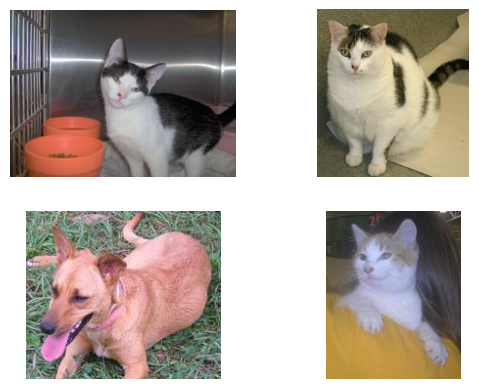

In [9]:
# display couple of random images

data_sample = data.sample(5).reset_index()

# print(data_sample.loc[1, 'filepath'])
for i in range(1,5):
    path = data_sample.loc[i, 'filepath']
    img = plt.imread(path)
    plt.subplot(2,2,i)
    plt.imshow(img)
    plt.axis('off')
    
    

In [10]:
# split the data tot train in test 80/20
X_train, X_test_val = train_test_split(data, test_size=0.2, random_state=7)

#split test to test and val 50/50
X_test, X_val = train_test_split(X_test_val, test_size=0.5, random_state=7)


In [31]:
#create a data generators
BATCH_SIZE = 128

datagen_train = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# datagen for val
datagen_val = ImageDataGenerator(
    rescale=1/255.)

# generators for data loading
train_generator = datagen_train.flow_from_dataframe(
    dataframe=X_train,
    x_col='filepath',
    y_col='label',
    target_size=(227, 227),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    workers=4,
    use_multiprocessing=True
)

val_generator = datagen_val.flow_from_dataframe(
    dataframe=X_val,
    x_col='filepath',
    y_col='label',
    target_size=(227, 227),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    workers=4,
    use_multiprocessing=True
)

test_generator = datagen_val.flow_from_dataframe(
    dataframe=X_test,
    x_col='filepath',
    y_col='label',
    target_size=(227, 227),
    batch_size=BATCH_SIZE,
    class_mode='binary',
)


Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [25]:
# Alex Net architecture implemented from scratch
def Alex_Net(weights = None, skip_mismatch=False, include_top = False, input_shape=(227, 227, 3)):
    '''
    Alex Net implementation from scratch in Keras
    The weights are not included ,however, implemented
    the compatibility with loading custom weights. 
    
    weights - parameter for filepath to weights to load weights.
    By default initiated to None and no weights are used. 
    include_top - whether to include the fully-connected layer at the top of the network.
    skip_mismatch - whether to skip mismatched layers when loading weights.
    '''  
    input_lyr = Input(shape=input_shape)
    # Conv Layer 1
    x =  Conv2D(96, (11,11), strides=(4,4), padding='valid', activation='relu')(input_lyr)
    x = BatchNormalization()(x) # instead of LRN
    x = MaxPool2D((3,3), strides=(2,2))(x)
    # Conv Layer 2
    x = Conv2D(256, (5,5), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) # instead of LRN
    x = MaxPool2D((3,3), strides=(2,2))(x)
    # Conv Layers 3-5 (they are all the same)
    x = Conv2D(384, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(384, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = MaxPool2D((3,3), strides=(2,2))(x)
    # FLC Layers 
    # if True: add the classic FLC layers of Alex Net
    if include_top:
        flatten = Flatten()(x)
        x = Dense(4096, activation='relu')(flatten)
        x = Dropout(0.5)(x)
        x = Dense(4096, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1000, activation='softmax')(x)
    model = Model(inputs=input_lyr, outputs=x)
    
    if weights is not None:
        try:
            model.load_weights(weights, skip_mismatch=skip_mismatch)
        except (IOError, OSError, ValueError) as err:
            print(f"Error loading weights: {err}")
    return model

# model = Alex_Net(include_top=False)

# model.summary()
# from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes=True)  

In [29]:
# we will not use top as we don't have the original weights and don't want to overcomplicate the model
alex_net_base = Alex_Net(include_top=False) # base model

x = alex_net_base.output # the base model as input

# FLC layers
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x) # output

model = Model(inputs=alex_net_base.input, outputs=out)

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 227, 227, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,928,513 (18.80 MB)

 Trainable params: 4,927,809 (18.80 MB)

 Non-trainable params: 704 (2.75 KB)

In [33]:
# compile the model
#optimiser
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#callbacks
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=15,
    verbose=1,
    restore_best_weights=True,
    mode="min")

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.6,
    patience=5,         
    min_lr=0.00001,
    verbose=1)
# compile 
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=val_generator,
                    callbacks=[early_stop, reduce_lr],
                   )

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.5463 - loss: 1.5409 - val_accuracy: 0.5728 - val_loss: 0.6743 - learning_rate: 0.0010
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.6048 - loss: 0.6578 - val_accuracy: 0.6232 - val_loss: 0.6359 - learning_rate: 0.0010
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.6531 - loss: 0.6228 - val_accuracy: 0.6488 - val_loss: 0.6246 - learning_rate: 0.0010
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.6878 - loss: 0.5884 - val_accuracy: 0.6620 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.7246 - loss: 0.5488 - val_accuracy: 0.7392 - val_loss: 0.5420 - learning_rate: 0.0010
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.7666 - loss: 0.5022 - val_accuracy: 0.7312 - val_loss: 0.5336 - learning_rate: 0.0010
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.7797 - loss: 0.4647 - val_

As we can see the final epoch's training accuracy was ~92% and val accuracy ~88 which is a good result for training Alex Net from scratch on a limited dataset of 20k images. The idea was to keep the model as closer as possible to the original architecture.  

Text(0.5, 0, 'Epoch')

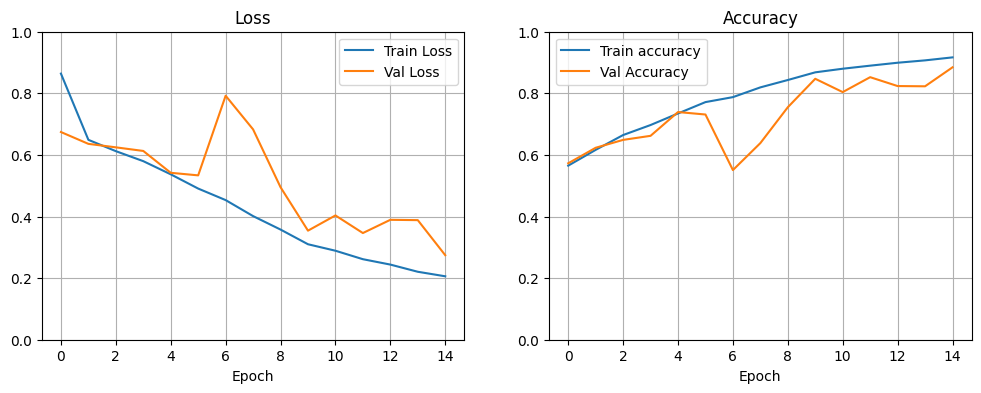

In [44]:
# plot the result
fig = plt.figure(figsize=(12, 4))

fig.add_subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.grid(True)
plt.ylim([0, 1])  
plt.title('Loss')
plt.xlabel('Epoch')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0, 1])  
plt.title('Accuracy')
plt.xlabel('Epoch')

In [47]:
# evaluate the model on a test set using test gen
test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.8732 - loss: 0.2709
Test Loss: 0.26859250664711
Test Accuracy: 0.8791999816894531


As we can see test accuracy is ~88 wich is a good result and macth the validation accuracy.